In [7]:
def add_white_noise(image, snr_db):

#      # Ensure image is in float format for precise calculations
#     image = image.astype(np.float64)
    # Calculate the power of the original signal (image)
    signal_power = np.mean(image**2)
    
    # Calculate the power of the noise based on the desired SNR (in dB)
    snr_linear = 10**(snr_db / 10)
    # Calculate the noise power based on the desired SNR (in dB)
    noise_power = signal_power / (10**(snr_db / 10))

    
    # Generate noise with the calculated power and zero mean
    noise = np.random.normal(0, np.sqrt(noise_power), image.shape)
    
    # Add the generated noise to the original image
    noisy_image = image + noise
    
    # Clip the values to be in the valid range (0, 255) for image data
    noisy_image = np.clip(noisy_image, 0, 255)

    #  # Convert the image back to unsigned 8-bit format
    # noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
original_image = cv2.imread('new_york.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian smoothing
smoothed_image = cv2.GaussianBlur(original_image, (0, 0), sigmaX=1.5)  # You can adjust sigmaX here

# Add white Gaussian noise
degraded_image = add_white_noise(smoothed_image, snr_db=7)  # Use the provided function


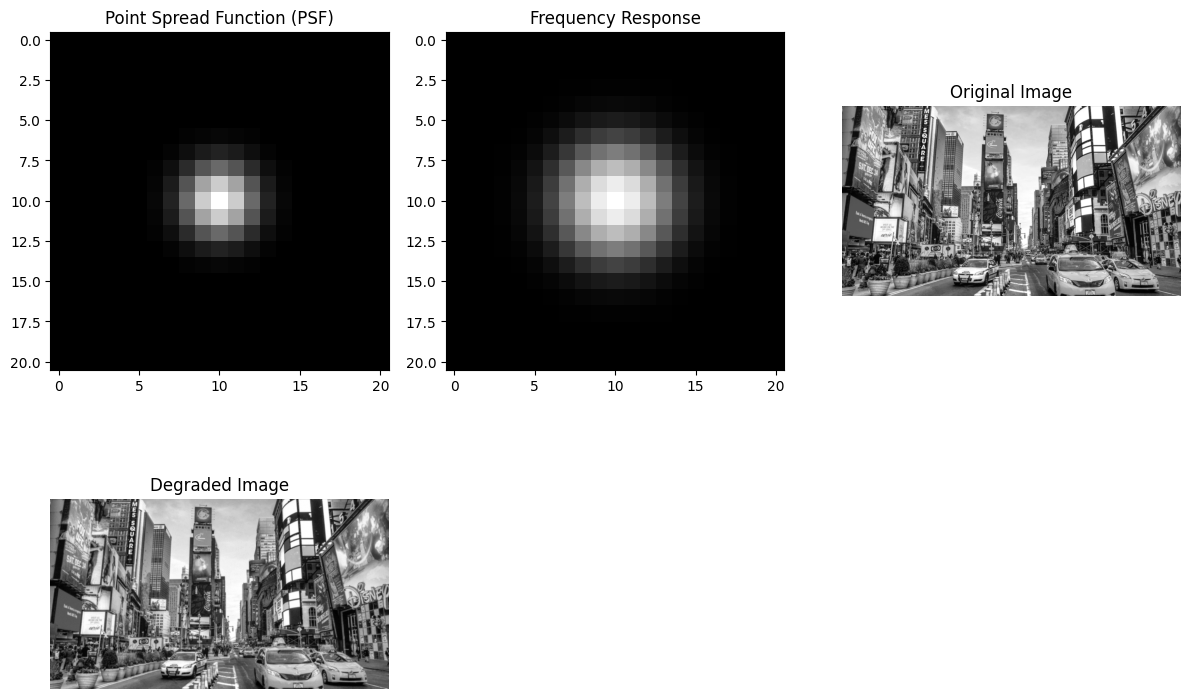

In [9]:
# Calculate the PSF
psf = cv2.getGaussianKernel(21, sigma=1.5) * cv2.getGaussianKernel(21, sigma=1.5).T

# Calculate the frequency response
frequency_response = np.fft.fftshift(np.fft.fft2(psf))

# Plot PSF, frequency response, original, and degraded images
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(psf, cmap='gray')
plt.title('Point Spread Function (PSF)')
# plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.log(np.abs(frequency_response) + 1), cmap='gray')
plt.title('Frequency Response')
# plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image')
plt.axis('off')

plt.tight_layout()
plt.show()


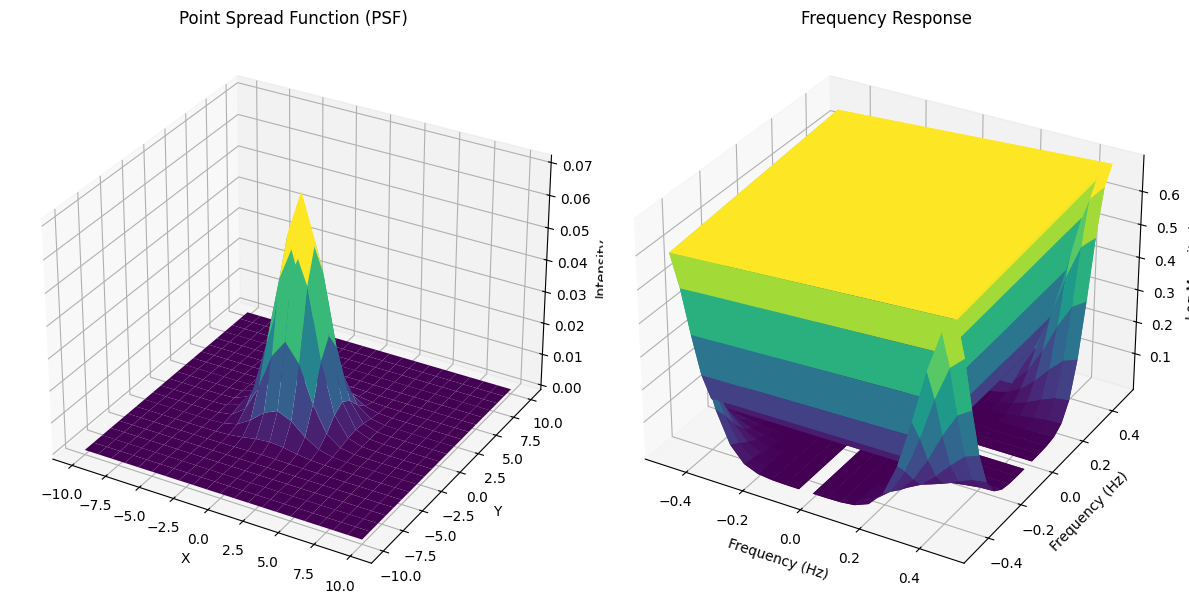

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Create grid for PSF
x = np.linspace(-10, 10, 21)
y = np.linspace(-10, 10, 21)
X, Y = np.meshgrid(x, y)

# Plot PSF
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, psf, cmap='viridis')
ax1.set_title('Point Spread Function (PSF)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Intensity')

# Create grid for frequency response
f_x = np.fft.fftfreq(21, d=1)
f_y = np.fft.fftfreq(21, d=1)
F_X, F_Y = np.meshgrid(f_x, f_y)

# Plot frequency response
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(F_X, F_Y, np.log(np.abs(frequency_response) + 1), cmap='viridis')
ax2.set_title('Frequency Response')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_zlabel('Log Magnitude')

plt.tight_layout()
plt.show()


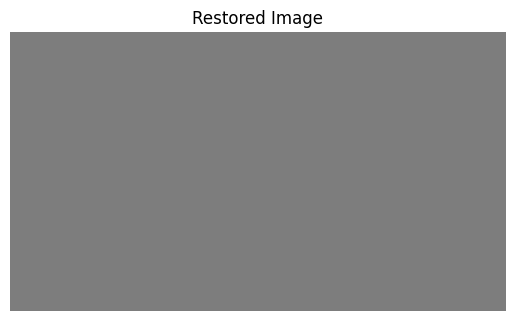

In [17]:
wiener_filter = np.conj(frequency_response) / (np.abs(frequency_response) ** 2 + 1 / 7)

# Convert Wiener filter to real-valued array
wiener_filter_real = np.real(wiener_filter)

# Perform Wiener deconvolution
wiener_filter_resized = cv2.resize(wiener_filter_real, (degraded_image.shape[1], degraded_image.shape[0]))  # Resize Wiener filter to match image size
restored_image = np.fft.ifft2(np.fft.fft2(degraded_image) * wiener_filter_resized).real

# Normalize the restored image values to the range [0, 255]
restored_image_normalized = (restored_image - np.min(restored_image)) * (255.0 / (np.max(restored_image) - np.min(restored_image)))

# Convert the normalized image to uint8
restored_image_uint8 = np.clip(restored_image_normalized, 0, 255).astype(np.uint8)

# Display the restored image
plt.imshow(restored_image_uint8, cmap='gray')
plt.title('Restored Image')
plt.axis('off')
plt.show()

